# Visual Studio Code - Python Data Science Tutorial

https://code.visualstudio.com/docs/python/data-science-tutorial

Import modules and load data

Data source: http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.html  
Data info: http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt  
OpenML: https://www.openml.org/d/40945

## Prepare the Data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('titanic.csv')

Examine the data type of each property in the data set.

Property | Description | Values
---------|-------------|-------
`pclass` | Passenger Class | 1 = 1st; 2 = 2nd; 3 = 3rd
`survival` | Survival | 0 = No; 1 = Yes
`name` | Name | 
`sex` | Sex | 
`age` | Age | 
`sibsp` | Number of Siblings / Spouses Aboard | 
`parch` | Number of Parents / Children Aboard | 
`ticket` | Ticket Number | 
`fare` | Passenger Fare | Pre-1970 British Pounds
`cabin` | Cabin | 
`embarked` | Port of Embarkation | C = Cherbourg; Q = Queenstown; S = Southampton
`boat` | Lifeboat | 
`body` | Body Identification Number | 
`home.dest` | Home / Destination

**Definitions for `sibsp` and `parch`**  
Sibling: Borther, Sister, Stebrother, or Stepsister of passenger aboard Titanic  
Spouse: Husband or Wife of passenger aboard Titanic (Mistresses and Fiances ignored)  
Parent: Mother or Father of passenger aboard Titanic  
Child: Son, Daughter, Stepson, or Stepdaughter of passenger aboard Titanic

In [2]:
data.dtypes

pclass        int64
survived      int64
name         object
sex          object
age          object
sibsp         int64
parch         int64
ticket       object
fare         object
cabin        object
embarked     object
boat         object
body         object
home.dest    object
dtype: object

Ensure that unknown data is replaced with an appropriate type, and format the `age` and `fare` properties from `object` to `float64`

In [3]:
data.replace('?', np.nan, inplace= True)
data = data.astype({"age": np.float64, "fare": np.float64})

View how certain columns of the dataset relate to survivability.

<AxesSubplot:xlabel='survived', ylabel='fare'>

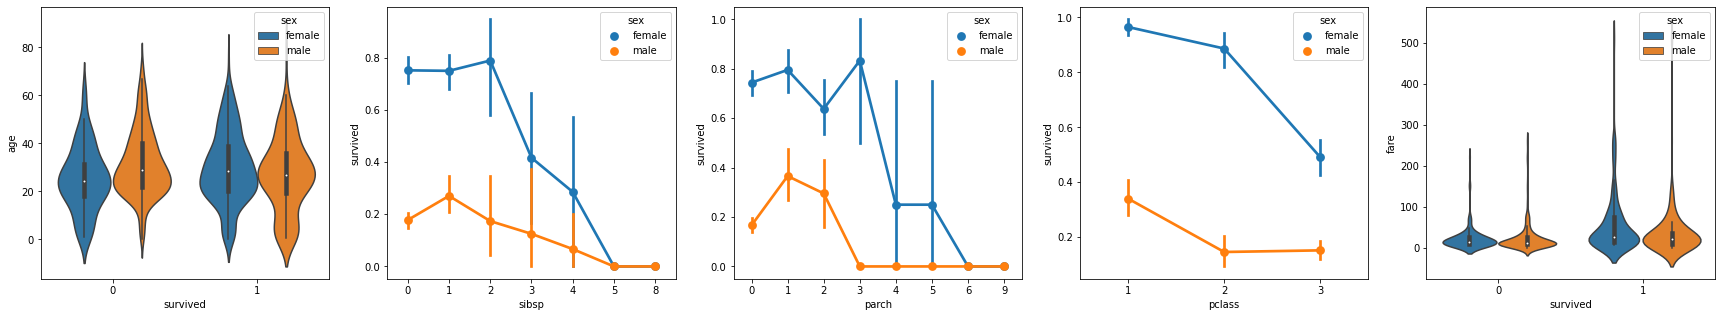

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])

Calculate how numeric properties correlate to survival.

In [5]:
data.replace({'male': 1, 'female': 0}, inplace= True)
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265


Hypotehsize that `sibsp` and `parch` are related in how they affect survivability, and group them into a new column called "relatives" to see whether the combination of them has a higher correlation to survivability.

In [6]:
data['relatives'] = data.apply(lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265
relatives,0.201719


Drop from the dataset the low value `sibsp` and `parch` columns, as well as any rows that had **NaN** values, to end up with a dataset that can be used for training a model.

> Although age had a low direct correlation, it was kept because it seems reasonable that it might have correlation in conjunction with other inputs.

In [7]:
data = data[['sex', 'pclass', 'age', 'relatives', 'fare', 'survived']].dropna()

## Train and Evaluate a Model

Split data into training and validation data.

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data[['sex', 'pclass', 'age', 'relatives', 'fare']], data.survived, test_size=0.2, random_state=0)

Normalize the inputs such that all features are treated equally. Within the dataset the values for age range from ~0-100, while gender is only a 1 or 0. By normalizing the variables, you can ensure that the ranges of values are all the same.

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

Model the data using the Naive Bayes algorithm, a common algorithm for classification problems.

In [10]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

With a trained model, you can now try it against the data set.

In [11]:
from sklearn import metrics
predict_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))

0.7464114832535885


## Use a Neural Network to Increase Accuracy

A neural network is a model that uses weights and activation functions, modeling aspects of human neurons, to determine an outcome based on provided inputs. Neural networks are a form of deep learning wherein you don't need to know an ideal algorithm for your problem set ahead of time.

Import required libraries and use a [Sequential](https://keras.io/getting-started/sequential-model-guide/) neural network, which is a layered neural network wherin there are multiple layers that feed into each other in sequence.

In [12]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Add the layers to the neural network.

* The first layer will be set to have a dimension of 5, since you have 5 inputs: `sex`, `pclass`, `age`, `relatives`, and `fare`.
* The last layer must output 1, sinc you want a 1-dimensional output indicating whether a passenger would survive.
* The middle layer was kept at 5 for simplicity, although the value could have been different.

The rectified linear unit (relu) activation function is used as a good general activation function for the first two layers, while the sigmoid activation function is required for the final layer as the output you want (of whether a passenger survives or not) needs to be scaled in the range of 0-1 (the probability of a passenger surviving).

In [13]:
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 5))
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

You can look at the summary of the model as follows:

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


Once the model is created, it needs to be compiled. As part of this, you need to define what type of optimizer will be used, how loss will be calculated, and what metric should be optimized for.

In [15]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpendnwvik.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpendnwvik.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
27/27 [==============================] - 8s 692us/step - loss: 0.6925 - accuracy: 0.6207
Epoch 2/50
27/27 [==============================] - 0s 655us/step - loss: 0.6900 - accuracy: 0.5869
Epoch 3/50
27/27 [==============================] - 0s 654us/step - loss: 0.6852 - accuracy: 0.5698
Epoch 4/50
27/27 [==============================] - 0s 731us/step - loss: 0.6744 - accuracy: 0.5

With the model trained, check performance against the test data.

In [16]:
y_pred = model.predict_classes(X_test)
print(metrics.accuracy_score(y_test, y_pred))

g:\code\learning\python\vscode-setup\.venv\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
0.8038277511961722
